***Sequence prediction with CNN and LR optimization***

dataset is NASDAQ open and close 10 year history


In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [53]:
NASDAQ_CSV = 'd:/data/stocks/nasdaq1984.csv'

with open(NASDAQ_CSV, 'r') as csvfile:
    print(f"Header looks like this           :  {csvfile.readline()}")    
    print(f"First data point looks like this :  {csvfile.readline()}")
    print(f"Second data point looks like this:  {csvfile.readline()}")

Header looks like this           :  Date,Open,High,Low,Close,Adj Close,Volume

First data point looks like this :  10/11/1984,244.199997,244.699997,244.199997,244.699997,244.699997,62860000

Second data point looks like this:  10/12/1984,245.5,246.199997,245.5,246.199997,246.199997,58860000



**Create plot function**

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

**Parse the .csv data**

In [54]:
def parse_data_from_file(filename):
    
    date = []
    close = []
    volume= []

    with open(filename) as csvfile:
       
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
     
        for record in reader:
            date.append(date[0])
            close.append(float(record[4]))
            volume.append(float(record[6]))
 
        days=list(range(0,len(sequence0)))
    
    print(len(days), len(date))
            
    return days, date, close, volume


**Create Globals**

2547 2547


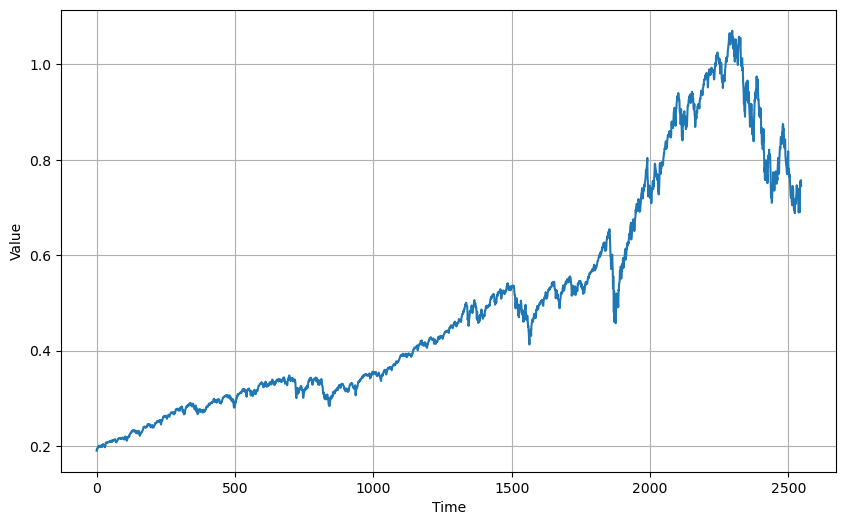

In [5]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    NASDAQ_CSV = 'd:/data/stocks/10yearnasdaq.csv'
    times, open, close = parse_data_from_file(NASDAQ_CSV)
    TIME = np.array(times)
    SERIES = np.flip(np.array(np.divide(close,15000)))
    SPLIT_TIME = 2547-251
    WINDOW_SIZE = 64
    BATCH_SIZE = 512
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Do Train and Validation split**

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)
print ('First 3 [time] [train]  ', time_train[0:3], series_train[0:3])
print ('Split at   :',G.SPLIT_TIME)
print ('WINDOW_SIZE:',G.WINDOW_SIZE)
print ('All        :',np.shape(G.TIME))
print ('Train      :',np.shape(time_train))
print ('Validation :',np.shape(time_valid))

First 3 [time] [train]   [0 1 2] [0.19020867 0.19440467 0.19444533]
Split at   : 2296
WINDOW_SIZE: 64
All        : (2547,)
Train      : (2296,)
Validation : (251,)


***Create windowed dataset***

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    #ds = ds.shuffle(shuffle_buffer)  # uncomment shuffle for prod
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=64, batch_size=G.BATCH_SIZE, shuffle_buffer=1000)
valid_set = windowed_dataset(series_valid, window_size=64, batch_size=G.BATCH_SIZE, shuffle_buffer=1000)
print ('train set shape: ',np.shape(train_set))
print (type(train_set),'\n')
for elem in train_set:
    print(elem[0],'\n\n')
    print('current data shape       : ',np.shape(elem[0])) 
    x=tf.expand_dims(elem[0], axis=-1)
    print('need this shape for model: ',np.shape(x))
    break


train set shape:  ()
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 

tf.Tensor(
[[0.19020867 0.19440467 0.19444533 ... 0.2128     0.21243267 0.21312533]
 [0.19440467 0.19444533 0.19510333 ... 0.21243267 0.21312533 0.213244  ]
 [0.19444533 0.19510333 0.19510333 ... 0.21312533 0.213244   0.212802  ]
 ...
 [0.30440933 0.308716   0.30926067 ... 0.317192   0.31811733 0.3121    ]
 [0.308716   0.30926067 0.30824267 ... 0.31811733 0.3121     0.30919933]
 [0.30926067 0.30824267 0.308048   ... 0.3121     0.30919933 0.31222733]], shape=(512, 64), dtype=float64) 


current data shape       :  (512, 64)
need this shape for model:  (512, 64, 1)


**Define the tuning model**

In [8]:
def create_uncompiled_model(modelnum=0):


    if modelnum==0:
        model = tf.keras.models.Sequential([ 
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(1)])
        
    elif modelnum==1:
        model = tf.keras.models.Sequential([
             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]), # adds the required depth dim
             tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu',input_shape=(64,1) ),
             tf.keras.layers.LSTM(64, return_sequences=True),
             tf.keras.layers.LSTM(64),
             tf.keras.layers.Dense(1)]) 
    
    elif modelnum==2:
        model = tf.keras.models.Sequential([
             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]), # adds the required depth dim
             tf.keras.layers.LSTM(64, return_sequences=True),
             tf.keras.layers.LSTM(64, return_sequences=True),
             tf.keras.layers.LSTM(64),
             tf.keras.layers.Dense(32),
             tf.keras.layers.Dense(1)]) 
    
    return model

In [9]:
# Test your uncompiled model
print("window:",G.WINDOW_SIZE)
print("batch :",G.BATCH_SIZE)
print("train_set:",train_set)
for element in train_set:
    print("train_set element shape: ",np.shape(element[0]))
    break

uncompiled_model = create_uncompiled_model(2)
uncompiled_model.summary()

for element in train_set:
    uncompiled_model.predict(element[0])

try:
    uncompiled_model.predict(train_set)
except:
    print("\Fail")
else:
    print("\nSuccess")

window: 64
batch : 512
train_set: <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
train_set element shape:  (512, 64)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None,

**Test a range of learning rates** 
- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [10]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5,momentum=.5)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [11]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)


Epoch 1/100
5/5 [==============================] - 5s 26ms/step - loss: 0.1400 - mae: 0.4848
Epoch 2/100
5/5 [==============================] - 0s 39ms/step - loss: 0.1388 - mae: 0.4825
Epoch 3/100
5/5 [==============================] - 0s 38ms/step - loss: 0.1374 - mae: 0.4797
Epoch 4/100
5/5 [==============================] - 0s 38ms/step - loss: 0.1358 - mae: 0.4765
Epoch 5/100
5/5 [==============================] - 0s 36ms/step - loss: 0.1341 - mae: 0.4729
Epoch 6/100
5/5 [==============================] - 0s 36ms/step - loss: 0.1322 - mae: 0.4690
Epoch 7/100
5/5 [==============================] - 0s 37ms/step - loss: 0.1301 - mae: 0.4646
Epoch 8/100
5/5 [==============================] - 0s 39ms/step - loss: 0.1277 - mae: 0.4597
Epoch 9/100
5/5 [==============================] - 0s 38ms/step - loss: 0.1251 - mae: 0.4543
Epoch 10/100
5/5 [==============================] - 0s 38ms/step - loss: 0.1223 - mae: 0.4482
Epoch 11/100
5/5 [==============================] - 0s 37ms/step - lo

5/5 [==============================] - 0s 36ms/step - loss: 0.3592 - mae: 0.7405
Epoch 88/100
5/5 [==============================] - 0s 37ms/step - loss: 0.3128 - mae: 0.6587
Epoch 89/100
5/5 [==============================] - 0s 37ms/step - loss: 0.2809 - mae: 0.6261
Epoch 90/100
5/5 [==============================] - 0s 37ms/step - loss: 0.3546 - mae: 0.6997
Epoch 91/100
5/5 [==============================] - 0s 38ms/step - loss: 0.4273 - mae: 0.7812
Epoch 92/100
5/5 [==============================] - 0s 39ms/step - loss: 1.0798 - mae: 1.5499
Epoch 93/100
5/5 [==============================] - 0s 37ms/step - loss: 1.1012 - mae: 1.5966
Epoch 94/100
5/5 [==============================] - 0s 38ms/step - loss: 0.7129 - mae: 1.0628
Epoch 95/100
5/5 [==============================] - 0s 36ms/step - loss: 1.2214 - mae: 1.6148
Epoch 96/100
5/5 [==============================] - 0s 41ms/step - loss: 0.6123 - mae: 0.9537
Epoch 97/100
5/5 [==============================] - 0s 36ms/step - loss: 

(0.001, 1.0, 0.0, 0.01)

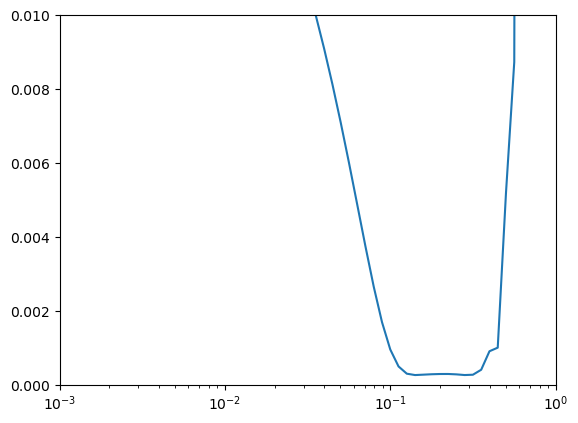

In [12]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-3, 1, 0, .01])

**Create the runtime model**

In [13]:
def create_model():
    model = create_uncompiled_model()  #reuse model defined above   
    return model

model = create_model()
model.summary()
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          8704      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


**Compile and train**

In [52]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(momentum=0.25, learning_rate=2e-1 ),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=1.e-1 ),
              metrics=["mae"])  
    
history = model.fit(train_set, epochs=300,verbose=0, validation_data=valid_set)

**Review results**

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


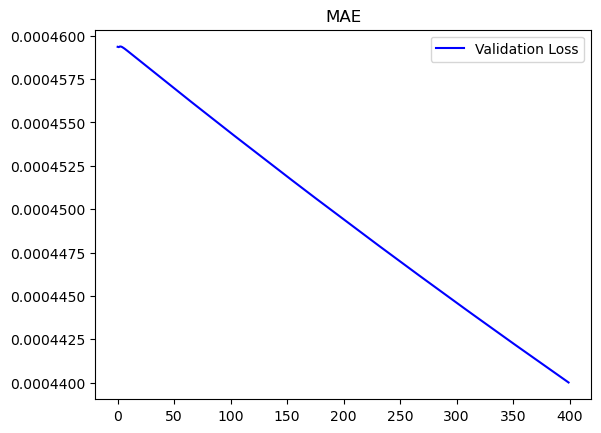

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

print(history)
print(history.history.keys())

acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Accuracy')
#plt.legend(loc=0)
#plt.figure()
#plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

#plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('MAE')
plt.legend(loc=0)
plt.figure()
plt.show()

**Evaluate the forecast**

In [24]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

**Create windowed dataset for simulation**

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

**Run predictions**

today's close       : 11183.66
tomorrow's forecast : 11270.17
gain of: 86.51 points or 0.77%



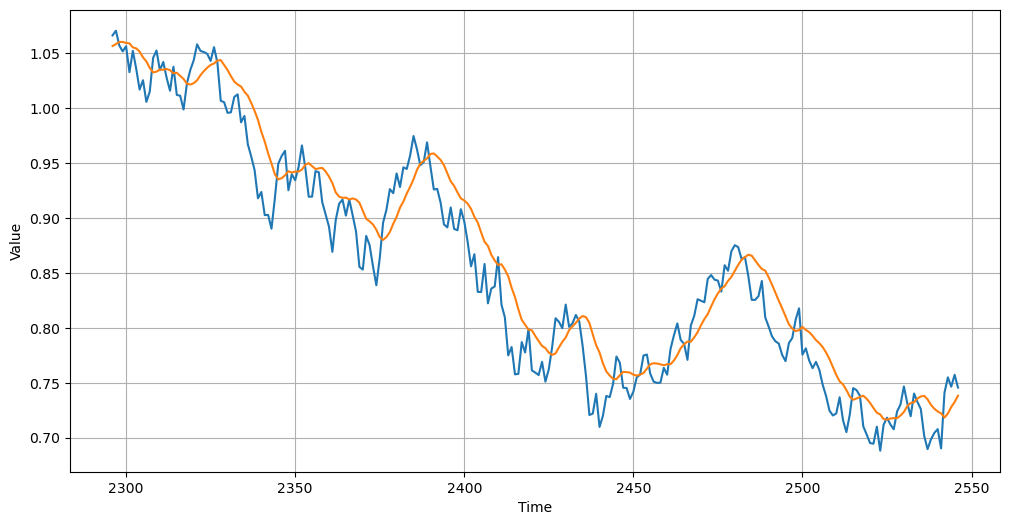

In [47]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


# Plot the forecast
plt.figure(figsize=(12, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)
#print(np.shape(rnn_forecast))
close=series_valid[-1]*15000.
tomorrow_forecast=(float(rnn_forecast[-1])-float(rnn_forecast[-2]))*15000+close
gain_points=tomorrow_forecast-close
percent=gain_points/close*100.

print("today's close       :",close)
print("tomorrow's forecast : {:.2f}".format(tomorrow_forecast))
print("gain of: {:.2f} points or {:.2f}%\n".format(gain_points,percent))

In [27]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.3f}, mae: {mae:.3f} for forecast")

mse: 0.001, mae: 0.028 for forecast


In [50]:
all_in=False
wallet=10000.
shares=0
for i in range(1,len(rnn_forecast)):
    if rnn_forecast[i]>series_valid[i-1] and all_in is False:
        print ('buying at {:.0f}'.format(float(series_valid[i-1])*15000))
        all_in =True
        shares=wallet/float(series_valid[i-1])/15000.
        wallet=0
    if rnn_forecast[i]<series_valid[i-1] and all_in is True:
        print ('selling at {:.0f}'.format(float(series_valid[i-1])*15000.))
        all_in = False
        wallet=shares*float(series_valid[i-1])*15000
        shares=0
    close=series_valid[i]*15000
    wealth=wallet+shares*close
    buyhold=10000.*series_valid[i]/series_valid[0]

    print('Day:{:02d} Shares:{:.0f} Close:{:.0f}  Value: ${:.2f}  Cash ${:.2f}  Total wealth is: ${:.2f} vs ${:.2f} for B&H, {:.1f}% better.'.format(i,shares, close, shares*close,wallet, wealth,buyhold,(wealth/buyhold-1)*100))


    

Day:01 Shares:0 Close:16057  Value: $0.00  Cash $10000.00  Total wealth is: $10000.00 vs $10039.85 for B&H, -0.4% better.
Day:02 Shares:0 Close:15855  Value: $0.00  Cash $10000.00  Total wealth is: $10000.00 vs $9913.12 for B&H, 0.9% better.
buying at 15855
Day:03 Shares:1 Close:15775  Value: $9949.78  Cash $0.00  Total wealth is: $9949.78 vs $9863.34 for B&H, 0.9% better.
Day:04 Shares:1 Close:15845  Value: $9993.99  Cash $0.00  Total wealth is: $9993.99 vs $9907.16 for B&H, 0.9% better.
Day:05 Shares:1 Close:15492  Value: $9770.98  Cash $0.00  Total wealth is: $9770.98 vs $9686.10 for B&H, 0.9% better.
Day:06 Shares:1 Close:15783  Value: $9954.63  Cash $0.00  Total wealth is: $9954.63 vs $9868.15 for B&H, 0.9% better.
Day:07 Shares:1 Close:15538  Value: $9800.02  Cash $0.00  Total wealth is: $9800.02 vs $9714.88 for B&H, 0.9% better.
Day:08 Shares:1 Close:15254  Value: $9621.12  Cash $0.00  Total wealth is: $9621.12 vs $9537.53 for B&H, 0.9% better.
Day:09 Shares:1 Close:15381  Value

**Save Model**

In [42]:
# Save your model into a HDF5 file
filename=input("Enter filename: ")+".h5"
print('Saving file: ',filename)
model.save(filename)

Enter filename: temp
Saving file:  temp.h5
